In [31]:
import pandas as pd
import torch
import torchvision
import numpy as np
import os
import cv2
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.ops.boxes import nms

In [32]:
train_data = pd.read_csv("data/train_labels.csv")
train_data = train_data[train_data["height"] == 512]
train_data.drop(["height", 'width'], inplace=True, axis=1)
train_data['bbox'] = train_data[['xmin', 'ymin', 'xmax' , 'ymax']].apply(list, axis=1)
train_data['class'] = train_data['class'].map({'Stenosis': 1})
train_data = train_data.drop(columns=['xmin', 'ymin', 'xmax' , 'ymax']).groupby('filename', as_index=False).agg(list)
train_data_300 = train_data.sample(n=30)
train_data_300

,filename,class,bbox
113,14_010_1_0037.bmp,[1],"[[125, 227, 171, 266]]"
929,14_051_8_0016.bmp,[1],"[[134, 96, 190, 115]]"
676,14_044_3_0042.bmp,[1],"[[222, 290, 238, 302]]"
344,14_021_34_0030.bmp,[1],"[[370, 152, 396, 174]]"
217,14_017_1_0033.bmp,[1],"[[206, 196, 229, 213]]"
323,14_021_32_0022.bmp,[1],"[[398, 200, 427, 230]]"
815,14_050_9_0020.bmp,[1],"[[259, 131, 272, 165]]"
1393,14_094_3_0052.bmp,[1],"[[207, 107, 233, 147]]"
1333,14_076_4_0026.bmp,[1],"[[198, 137, 261, 165]]"
604,14_040_7_0009.bmp,[1],"[[86, 208, 101, 235]]"


In [33]:
val_data = train_data.loc[train_data.index.difference(train_data_300.index)].sample(n = 5).reset_index(drop=True)
train_data = train_data_300.reset_index(drop=True)

In [34]:
train_data

,filename,class,bbox
0,14_010_1_0037.bmp,[1],"[[125, 227, 171, 266]]"
1,14_051_8_0016.bmp,[1],"[[134, 96, 190, 115]]"
2,14_044_3_0042.bmp,[1],"[[222, 290, 238, 302]]"
3,14_021_34_0030.bmp,[1],"[[370, 152, 396, 174]]"
4,14_017_1_0033.bmp,[1],"[[206, 196, 229, 213]]"
5,14_021_32_0022.bmp,[1],"[[398, 200, 427, 230]]"
6,14_050_9_0020.bmp,[1],"[[259, 131, 272, 165]]"
7,14_094_3_0052.bmp,[1],"[[207, 107, 233, 147]]"
8,14_076_4_0026.bmp,[1],"[[198, 137, 261, 165]]"
9,14_040_7_0009.bmp,[1],"[[86, 208, 101, 235]]"


In [35]:
val_data

,filename,class,bbox
0,14_017_1_0028.bmp,[1],"[[220, 192, 246, 212]]"
1,14_055_6_0019.bmp,[1],"[[87, 153, 124, 176]]"
2,14_067_4_0014.bmp,[1],"[[268, 220, 292, 278]]"
3,14_002_8_0011.bmp,[1],"[[260, 172, 287, 193]]"
4,14_010_6_0034.bmp,[1],"[[94, 250, 134, 287]]"


In [36]:
class MyDataset(Dataset):

    def __init__(self, dataframe, img_path):

        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_name = self.df.loc[index,'filename']
        boxes = torch.Tensor(self.df.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        return img, target

def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2, pretrained=False).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = MyDataset(train_data, 'data\dataset')
val_dataset = MyDataset(val_data, 'data\dataset')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn
)
for i, data in enumerate(train_data_loader):
    print(i, data)
val_data_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    collate_fn=collate_fn
)

C:\Projects\SFU\Coronarography\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Projects\SFU\Coronarography\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


0 ((tensor([[[0.2784, 0.2980, 0.3176,  ..., 0.4353, 0.3961, 0.3647],
         [0.2863, 0.2980, 0.3176,  ..., 0.4549, 0.4235, 0.3725],
         [0.2941, 0.3059, 0.3176,  ..., 0.4706, 0.4157, 0.3647],
         ...,
         [0.0588, 0.0706, 0.0627,  ..., 0.0196, 0.0196, 0.0000],
         [0.0627, 0.0706, 0.0588,  ..., 0.0118, 0.0118, 0.0039],
         [0.0588, 0.0588, 0.0510,  ..., 0.0039, 0.0039, 0.0118]],

        [[0.2784, 0.2980, 0.3176,  ..., 0.4353, 0.3961, 0.3647],
         [0.2863, 0.2980, 0.3176,  ..., 0.4549, 0.4235, 0.3725],
         [0.2941, 0.3059, 0.3176,  ..., 0.4706, 0.4157, 0.3647],
         ...,
         [0.0588, 0.0706, 0.0627,  ..., 0.0196, 0.0196, 0.0000],
         [0.0627, 0.0706, 0.0588,  ..., 0.0118, 0.0118, 0.0039],
         [0.0588, 0.0588, 0.0510,  ..., 0.0039, 0.0039, 0.0118]],

        [[0.2784, 0.2980, 0.3176,  ..., 0.4353, 0.3961, 0.3647],
         [0.2863, 0.2980, 0.3176,  ..., 0.4549, 0.4235, 0.3725],
         [0.2941, 0.3059, 0.3176,  ..., 0.4706, 0.4157

In [38]:
def train(train_dataloader):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss

In [39]:
train_losses = []
val_losses = []
try:
    for epoch in range(20):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

	Итерация #0 loss: 1.3796247243881226
	Итерация #1 loss: 0.8234437704086304
	Итерация #2 loss: 0.516444981098175
	Итерация #3 loss: 0.26148954033851624
	Итерация #4 loss: 0.2166663408279419
	Итерация #5 loss: 0.14419978857040405
	Итерация #6 loss: 0.14688673615455627
	Итерация #7 loss: 0.19654449820518494
	Итерация #8 loss: 0.29360783100128174
	Итерация #9 loss: 0.18531976640224457
Эпоха #0 train_loss: 0.13880759924650193, val_loss: 0.05693596303462982
Потрачено 2.2 минут на 0 эпоху
	Итерация #0 loss: 0.1401604861021042
	Итерация #1 loss: 0.13788187503814697
	Итерация #2 loss: 0.11276103556156158
	Итерация #3 loss: 0.18126419186592102
	Итерация #4 loss: 0.2837604284286499
	Итерация #5 loss: 0.12567271292209625
	Итерация #6 loss: 0.24073576927185059
	Итерация #7 loss: 0.4390694200992584
	Итерация #8 loss: 0.18020330369472504
	Итерация #9 loss: 0.22643238306045532
Эпоха #1 train_loss: 0.06893138686815897, val_loss: 0.07720650434494018
Потрачено 2.2 минут на 1 эпоху
	Итерация #0 loss: 0.1

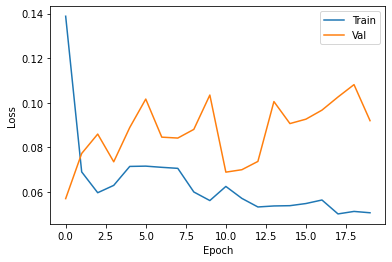

In [40]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()